# Task 1: Choose your agents

## Executive Summary

This notebook solves the problem of choosing 15 users from the Ubuntu chat dataset to become customer service agents. 

The 15 chosen users are:

* ActionParsnip
* Dr_Willis
* ikonia
* jrib
* edbian
* erUSUL
* Jordan_U
* bazhang
* theadmin
* soreau
* coz_
* iceroot
* DasEi
* dr_willis
* sebsebseb

The users were selected based on the total number of direct replies to other users and the number of times that they received thanks from other users. These were the users deemed to be most helpful and most experienced in my analysis. It was found that users who reply to many users directly also participate in many, many chats, making them more experienced in helping others. Interestingly, it was also found that users who are deemed to be more helpful and experienced, also tend to write very short messages in the long run. 

The rest of this notebook details the analysis that led to these conclusions. 


## Introduction

The instructions do not recommend specific criteria to select good candidates for customer service agent. Also, the dataset does not distnguish users who are "customers" (users seeking help with Ubuntu) from users who provide help (potential customer service agents). Based on common sense, I decided to select the users who tend to be most helpful in the chats. Ideally, we should be able to detect users who successfully solve questions based on user reactions. However, this would require doing a relatively deep analysis of answers given to customers and whether these customers found those answers helpful. Also, during a visual inspection of the data, I realised that many conversations end abruptly with no clear indication as to whether the issue was resolved or not. 

So I decided instead to gather some user statistcs on criteria that I believed could be good indicators of helpful users (potential customer service agents). Basically, I decided to identify users who:

* **Participate in as many conversations (chats) as possible.** Users who participate in many conversations presumably tend to answer queries. Users who participate in very few chats, are more than likely customers who seek help. 
* **Mostly directly address other users.** Users who mostly directly address other users are more likely to be helfpul users replying to user's queries.
* **Least open new conversations.** Users who open new conversations are users who need help. So find users who tend to not start new conversations.
* **Most thanked users.** Users who receive messages with *thank you*, *thanks*, *thx*, *thkx*, etc. have presumably helped someone. 

A priori I didn't know which of these criteria is the most useful. So I decided to first investigate them individually and rank users acording to each criterion and compare rankings. Afterwards, I combined the most useful rankings to select the final 15 users as customer agents. 

I also decided to look at the average message length that users produce. I didn't have an expectation a priori about whether this could be a good indication of agents or customers. But as we'll see later, I found that helpful users tend to write very short messages.


## Some Terminology

* **message**: an individual intervention by a user (line) in the dataset.
* **conversation** or **chat**: the set of messages that have the same `conversation_id` in the dataset.

## Loading data and computing some basic statistics

Here we do some initialisations, load the data and I write a function to calculate some basic statistics on all users: `user_stats`. 

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv("./data/ubuntu_support_extract.csv", keep_default_na=False)

`user_stats` returns a dataframe in which each row has the following stats for each user who ever writes a message:

* `chats`: total number of conversations (chats) the user participated in.
* `op`: total number of conversations (chats) the user started.
* `msgs`: total number of messages the user issued.
* `avg_msg_len`: average message length in character this user wrote.
* `msgs_ind`: total number of messages in which the user directly addressed another user (not messages addressed to whole channel with empty `to` field).

In [3]:
def user_stats(data):  # builds a dataframe of stats per user
    user2info = {}
    for convo_tup in data.groupby('conversation_id'):
        convo = convo_tup[1]
        first = True
        users_seen_in_convo = set()
        for row in range(convo.shape[0]):
            msg = convo.iloc[row]
            user = msg['from']
            chan_msg = msg['to'] == ""
            is_op = first
            user_rec = user2info.get(user, None)
            if user_rec is None:
                user_rec = { 'chats' : 0, 'op' : 0, 'msgs' : 0, 'avg_msg_len' : 0, 'msgs_ind' : 0 }
                user2info[user] = user_rec
            user_rec['msgs'] += 1
            user_rec['avg_msg_len'] =+ len(msg['text'])
            if not chan_msg:
                user_rec['msgs_ind'] += 1
            if user not in users_seen_in_convo:
                user_rec['chats'] += 1
                if is_op:
                    user_rec['op'] += 1
            users_seen_in_convo.add(user)
            first = False
    proto_df = {'user': [], 'chats': [], 'op': [], 'msgs': [], 'avg_msg_len': [], 'msgs_ind': []}
    for item in user2info.items():
        proto_df['user'].append(item[0])
        proto_df['chats'].append(item[1]['chats'])
        proto_df['op'].append(item[1]['op'])
        proto_df['msgs'].append(item[1]['msgs'])
        proto_df['avg_msg_len'].append(item[1]['avg_msg_len'] / item[1]['msgs'])  # piggy-back average computation
        proto_df['msgs_ind'].append(item[1]['msgs_ind'])
    return pd.DataFrame(proto_df)

Now let's run `user_stats` and save results into new dataframe `users`: 

In [4]:
users = user_stats(data)
users.head()

user  chats   op   msgs  avg_msg_len  msgs_ind
0         fk91      4    4     11     0.454545         3
1      sometux     63   32    327     0.128440       250
2      mrapple     17   17     80     0.900000        23
3       ikonia   5203  168  30715     0.000716     30342
4  tumenjargal     19   19    110     0.163636         2

In [5]:
users.shape

(92496, 6)

There are 92,496 users that wrote messages.

## Individual criteria rankings

So now let's look at how the individual criteria collected in `users` helps us determine the most helpful users. Let's see the top 30 users for each criterion. 

### `chats`

In [6]:
users.sort_values(by=['chats'], ascending=False).head(30)

user  chats   op   msgs  avg_msg_len  msgs_ind
89    ActionParsnip  10436  774  55125     0.000345     51484
33        Dr_Willis   7365  539  36626     0.004942     35021
118         bazhang   5707  197  17512     0.001256     17092
3            ikonia   5203  168  30715     0.000716     30342
60           erUSUL   4615  255  17653     0.001529     17058
73             jrib   4188  197  18491     0.021091     18093
465            Pici   3829  135   9269     0.001726      9013
2078      FloodBot1   3596    0   4452     0.019991      4452
413        theadmin   3505  234  13047     0.014256     12638
265       ZykoticK9   3318   99  10207     0.014990     10041
387        Jordan_U   3312  188  13537     0.007535     13294
52           xangua   3248  218   6588     0.003036      5986
109         iceroot   3217  104  12884     0.001552     12688
139             rww   3111  178   7721     0.001943      7310
29           edbian   3004  142  21307     0.003285     21079
39          IdleOne   2577  231   7155     0.003215      6675
25        dr_willis   2566  342  10642     0.001034      9293
105            coz_   2455   88  14329     0.007607     14130
124          soreau   2408  201  12472     0.004971     11992
197           llutz   2375  105   8477     0.008022      8263
112        guntbert   2202  228   6171     0.002917      5772
299            maco   2030   55   8254     0.000242      8171
721           DasEi   1916  148  11691     0.006928     11284
652        aeon-ltd   1833   58   5525     0.005973      5372
140       sebsebseb   1745  150  12826     0.000858     12444
4407         escott   1724   70   7513     0.002396      7407
180         acicula   1692  125   7232     0.002351      6787
6041      FloodBot2   1649    0   1971     0.045155      1971
252        BluesKaj   1629  195   5171     0.032682      4690
5055         KM0201   1591  143   7433     0.012915      7009

User ActionParsnip tops the list with over 10k chats. I decided to look for a few chats involving this user (visual inspection) and in most of them he/she seems to be helping other users. Take this example chat:

(Format is `conversation_id,datetime,from,to,text`)
```
10-10571,2010-05-20 17:09:00+00:00,khafiz,,"guys, isit possible to install UNR on my laptop. amd64?"
10-10571,2010-05-20 17:10:00+00:00,khafiz,,"guys, isit possible to install UNR on normal laptop?"
10-10571,2010-05-20 17:12:00+00:00,ActionParsnip,khafiz,"sure, i use UNR on my laptop here, works fine"
10-10571,2010-05-20 17:13:00+00:00,khafiz,ActionParsnip,how am i going to dualboot unr with my vista pre installed?
10-10571,2010-05-20 17:16:00+00:00,ActionParsnip,khafiz,"ubuntu desktop has a lower minimum system requirement, but UNR is optomised to give maximum screen realestate"
10-10571,2010-05-20 17:16:00+00:00,ActionParsnip,khafiz,some versions of itunes run with some versions of wine
10-10571,2010-05-20 17:16:00+00:00,khafiz,ActionParsnip,thx for the info
10-10571,2010-05-20 17:17:00+00:00,ActionParsnip,khafiz,unfortunately you have a media player form one of the most shortsighted closed minded companys
10-10571,2010-05-20 17:18:00+00:00,khafiz,ActionParsnip,im quite new in ubuntu. can u guide me on installing ubuntu once i dowloaded .
10-10571,2010-05-20 17:19:00+00:00,ActionParsnip,khafiz,"MD5 test the ISO, burn to CD as SLOWLY as possible and boot to the cd"
```

A similar story emerges with the other users I inspected in this list. Users who participate in a high number of chats seem to be helpful. There is however two glaring exceptions in this list: FloodBot1 and FloodBot2. They seem to be bots who issue canned messages when other users write many messages in short succession (flooding). Ideally, we would like to not consider these bots for agents. Notice that they never open new conversations (`op`=0). So, one way could be to just remove anybody who never opens new conversations. (By the way, notice also that these users have a relatively low number of op conversations. They all participate in thousands of conversations but have ever started only a few hundred). We'll look at `op` later. 

### `msgs_ind`

Let's now look at the number of messages directly addressed to other users. I take this number to be an approximation of the number of replies to other users. 

In [7]:
users.sort_values(by=['msgs_ind'], ascending=False).head(30)

user  chats   op   msgs  avg_msg_len  msgs_ind
89    ActionParsnip  10436  774  55125     0.000345     51484
33        Dr_Willis   7365  539  36626     0.004942     35021
3            ikonia   5203  168  30715     0.000716     30342
29           edbian   3004  142  21307     0.003285     21079
73             jrib   4188  197  18491     0.021091     18093
118         bazhang   5707  197  17512     0.001256     17092
60           erUSUL   4615  255  17653     0.001529     17058
105            coz_   2455   88  14329     0.007607     14130
387        Jordan_U   3312  188  13537     0.007535     13294
109         iceroot   3217  104  12884     0.001552     12688
413        theadmin   3505  234  13047     0.014256     12638
140       sebsebseb   1745  150  12826     0.000858     12444
124          soreau   2408  201  12472     0.004971     11992
721           DasEi   1916  148  11691     0.006928     11284
265       ZykoticK9   3318   99  10207     0.014990     10041
25        dr_willis   2566  342  10642     0.001034      9293
465            Pici   3829  135   9269     0.001726      9013
197           llutz   2375  105   8477     0.008022      8263
235       sacarlson   1415  120   8355     0.008378      8209
299            maco   2030   55   8254     0.000242      8171
1073          usr13   1363   97   8028     0.004111      7779
4407         escott   1724   70   7513     0.002396      7407
139             rww   3111  178   7721     0.001943      7310
5055         KM0201   1591  143   7433     0.012915      7009
180         acicula   1692  125   7232     0.002351      6787
39          IdleOne   2577  231   7155     0.003215      6675
4568        urlin2u   1349   80   6861     0.013992      6671
178            Gnea   1247  116   6966     0.014643      6642
775           histo   1220  116   6572     0.012934      6347
52           xangua   3248  218   6588     0.003036      5986

This ranked list is quite similar to the `chats` ranked list. Notice, however, that the two bots are not present here. 

Let's also look at the total number of messages (`msgs`) that users issue (regardless of whether it is in reply to another user or not):

In [8]:
users.sort_values(by=['msgs'], ascending=False).head(30)

user  chats   op   msgs  avg_msg_len  msgs_ind
89    ActionParsnip  10436  774  55125     0.000345     51484
33        Dr_Willis   7365  539  36626     0.004942     35021
3            ikonia   5203  168  30715     0.000716     30342
29           edbian   3004  142  21307     0.003285     21079
73             jrib   4188  197  18491     0.021091     18093
60           erUSUL   4615  255  17653     0.001529     17058
118         bazhang   5707  197  17512     0.001256     17092
105            coz_   2455   88  14329     0.007607     14130
387        Jordan_U   3312  188  13537     0.007535     13294
413        theadmin   3505  234  13047     0.014256     12638
109         iceroot   3217  104  12884     0.001552     12688
140       sebsebseb   1745  150  12826     0.000858     12444
124          soreau   2408  201  12472     0.004971     11992
721           DasEi   1916  148  11691     0.006928     11284
25        dr_willis   2566  342  10642     0.001034      9293
265       ZykoticK9   3318   99  10207     0.014990     10041
465            Pici   3829  135   9269     0.001726      9013
197           llutz   2375  105   8477     0.008022      8263
235       sacarlson   1415  120   8355     0.008378      8209
299            maco   2030   55   8254     0.000242      8171
1073          usr13   1363   97   8028     0.004111      7779
139             rww   3111  178   7721     0.001943      7310
4407         escott   1724   70   7513     0.002396      7407
5055         KM0201   1591  143   7433     0.012915      7009
180         acicula   1692  125   7232     0.002351      6787
39          IdleOne   2577  231   7155     0.003215      6675
178            Gnea   1247  116   6966     0.014643      6642
4568        urlin2u   1349   80   6861     0.013992      6671
52           xangua   3248  218   6588     0.003036      5986
775           histo   1220  116   6572     0.012934      6347

The `msgs` list is very, very similar to the `msgs_ind` list. This means that users who write many messages are mostly in reply to other users.

I also looked at the proportion of replies per user (total number of replies `msgs_ind` divided by total number of messages `msgs` per user):

In [9]:
users['p_msgs_ind'] = users['msgs_ind'] / users['msgs']
users.sort_values(by=['p_msgs_ind'], ascending=False).head(30)

user  chats  op  msgs  avg_msg_len  msgs_ind  p_msgs_ind
92495           Olathe      1   0    37     0.756757        37         1.0
27894     Kinetic|work      4   0    10     1.300000        10         1.0
68808        willowave      1   0     1   144.000000         1         1.0
68810             Ov3R      1   0     2    12.500000         2         1.0
68827         henrik__      1   0     1     3.000000         1         1.0
7841        Guest82337      2   0     5    18.200000         5         1.0
7842       shinobilord      2   0     6     7.333333         6         1.0
7843   smahs3dtw1tch3d      2   0     3     4.333333         3         1.0
68829            joeka      1   0     2    34.500000         2         1.0
80402             Stoy      1   0     1    77.000000         1         1.0
42453              io`      2   0     4     2.750000         4         1.0
68837      Camera_Dude      1   0     1    31.000000         1         1.0
42412       LifeIsPain      1   0     1    75.000000         1         1.0
42411           ubott2      5   0     6     4.833333         6         1.0
42408         Netham47      2   0     2     6.500000         2         1.0
68862        Ptptaylor      1   0     1   129.000000         1         1.0
42400               tv      2   0     3     5.666667         3         1.0
68880       quick_nick      2   0     2    94.500000         2         1.0
42451         lord1234      1   0     1    19.000000         1         1.0
88943         WilsonJr      1   0     1     7.000000         1         1.0
42496       theuser51_      1   0     1   160.000000         1         1.0
68791              ls3      4   0     7     8.142857         7         1.0
42484        norbertos      1   0     1    14.000000         1         1.0
75210        Bob_Dole_      3   0     7     5.142857         7         1.0
88959     nickgoodfate      1   0     1    42.000000         1         1.0
27881            toyol      1   0     2    13.000000         2         1.0
27882         nowonmai     16   0    63     0.349206        63         1.0
42483              m_W      1   0     1     2.000000         1         1.0
68779        gratidude      2   0     3    84.000000         3         1.0
42475          Samanta      1   0     1    31.000000         1         1.0

However, this ranked list is much different. Observe in this case that these users participate in very few chats. I did a visual inspection of some users (by reading their chats in the dataset), and some of them do seem to be helping other users. However, if I were to select users to become customer service agents, I would like to select users who have participated in many chats, as that would give me an indication that they have more experience helping users. Both `msgs` and `msgs_ind` give me a better indication of this property, as the top users in these two lists have participated in thousands of chats. 

Before giving up in the proportion of individual replies, I do a filtering so that I only consider users who have participated in at least 1000 chats:

In [10]:
users[users.chats >= 1000].sort_values(by=['p_msgs_ind'], ascending=False).head(30)

user  chats   op   msgs  avg_msg_len  msgs_ind  p_msgs_ind
6179    FloodBot3   1584    2   1940     0.045876      1940    1.000000
6041    FloodBot2   1649    0   1971     0.045155      1971    1.000000
2257    FloodBot4   1166    0   1409     0.063165      1409    1.000000
2078    FloodBot1   3596    0   4452     0.019991      4452    1.000000
756        sipior   1055   23   3719     0.016940      3694    0.993278
299          maco   2030   55   8254     0.000242      8171    0.989944
29         edbian   3004  142  21307     0.003285     21079    0.989299
3          ikonia   5203  168  30715     0.000716     30342    0.987856
105          coz_   2455   88  14329     0.007607     14130    0.986112
4407       escott   1724   70   7513     0.002396      7407    0.985891
109       iceroot   3217  104  12884     0.001552     12688    0.984787
265     ZykoticK9   3318   99  10207     0.014990     10041    0.983737
235     sacarlson   1415  120   8355     0.008378      8209    0.982525
387      Jordan_U   3312  188  13537     0.007535     13294    0.982049
5553    zykotick9   1098   45   3290     0.012158      3226    0.980547
4203          qin   1094   56   3749     0.015204      3676    0.980528
6795        oCean   1471   46   3733     0.009376      3656    0.979373
73           jrib   4188  197  18491     0.021091     18093    0.978476
118       bazhang   5707  197  17512     0.001256     17092    0.976016
2179       llutz_   1075   47   3932     0.010173      3834    0.975076
197         llutz   2375  105   8477     0.008022      8263    0.974755
1126  bastidrazor   1019   41   2519     0.005558      2453    0.973799
595         Slart   1219   61   4803     0.011451      4676    0.973558
465          Pici   3829  135   9269     0.001726      9013    0.972381
652      aeon-ltd   1833   58   5525     0.005973      5372    0.972308
4568      urlin2u   1349   80   6861     0.013992      6671    0.972307
140     sebsebseb   1745  150  12826     0.000858     12444    0.970217
9        airtonix   1138   70   5054     0.001781      4902    0.969925
1073        usr13   1363   97   8028     0.004111      7779    0.968984
413      theadmin   3505  234  13047     0.014256     12638    0.968652

At the top of the list I get four bots! This is because these bots always address users directly! Although, I do start getting some familiar users like ikonia, edbian, maco, ZykoticK9, etc., I really want a list with no bots. So, I discard the proportion of individual replies at this point. 

So far, `chats`, `msgs_ind` and `msgs` give me similar results: users who participate in many chats. I feel more comfortable choosing `msgs_ind` from these three lists. `msgs_ind` gives me users who participate in many, many chats and who mostly directly reply to users. 

### `op`

Now, let's have a look at users who mostly never open new messages:

In [11]:
users.sort_values(by=['op'], ascending=True).head(30)

user  chats  op  msgs  avg_msg_len  msgs_ind  p_msgs_ind
92495           Olathe      1   0    37     0.756757        37    1.000000
42673         Segfault      4   0    16     1.437500        16    1.000000
42672         mamakin_      1   0     1    26.000000         1    1.000000
81823        Gu3ss_Wh0      1   0     2    24.000000         2    1.000000
42661         openvoid      3   0     3    11.000000         3    1.000000
14336             epoh      1   0     1     2.000000         1    1.000000
81809           vindoz      1   0     1    29.000000         1    1.000000
42651        poundsign      1   0     2    24.500000         2    1.000000
42646         Emotions      1   0     1    21.000000         1    1.000000
14351        Random833      5   0    21     0.095238        15    0.714286
42635              qtx      1   0     1    54.000000         1    1.000000
42674  MasterOfMinutia      2   0     2    34.000000         2    1.000000
14360       wildbat000     11   0    29     0.172414        29    1.000000
14376           nicket      1   0     1    14.000000         1    1.000000
81772           Wildy_      1   0     3    12.333333         1    0.333333
42579         proxyman      2   0     5     9.800000         5    1.000000
42578        celloflax      1   0     1    95.000000         1    1.000000
14401        Kajayacht      1   0     1    93.000000         1    1.000000
14402           stego_      6   0    49     1.571429        48    0.979592
42568           boskee      3   0    45     2.911111        44    0.977778
42567      Billy_buntu      1   0     1    48.000000         1    1.000000
42563           paean_      4   0     7     1.714286         7    1.000000
42562        yurik3829      6   0    12     4.416667        12    1.000000
14363          cwraig2      3   0    13     2.307692        13    1.000000
65868         Mike9866      1   0     2    36.500000         2    1.000000
81831  MarshmallowGoat      1   0     2    47.000000         2    1.000000
42686        Colourful      1   0     1    44.000000         1    1.000000
65825            noize      1   0     2     3.000000         1    0.500000
65828  anon84687676798      1   0     1     8.000000         1    1.000000
42772         Froshell      1   0     1   172.000000         1    1.000000

We mostly get users who participate in very few chats. They really can't be good candidates. 

Out of curiosity, let's look at users who tend to open lots of new chats:

In [12]:
users.sort_values(by=['op'], ascending=False).head(30)

user  chats   op   msgs  avg_msg_len  msgs_ind  p_msgs_ind
89     ActionParsnip  10436  774  55125     0.000345     51484    0.933950
33         Dr_Willis   7365  539  36626     0.004942     35021    0.956179
25         dr_willis   2566  342  10642     0.001034      9293    0.873238
287          tripelb    430  255   1892     0.133192      1264    0.668076
60            erUSUL   4615  255  17653     0.001529     17058    0.966295
413         theadmin   3505  234  13047     0.014256     12638    0.968652
39           IdleOne   2577  231   7155     0.003215      6675    0.932914
2732            ruan    999  230   4058     0.005175      3288    0.810251
112         guntbert   2202  228   6171     0.002917      5772    0.935343
364           ubuntu    280  225   1342     0.023100       380    0.283159
52            xangua   3248  218   6588     0.003036      5986    0.908622
44            hiexpo    874  214   3375     0.006222      2748    0.814222
11806         uLinux    305  201   1600     0.025625      1023    0.639375
2342         Roasted    309  201   2057     0.011667      1630    0.792416
124           soreau   2408  201  12472     0.004971     11992    0.961514
7173           induz    211  197   1513     0.012558       769    0.508262
118          bazhang   5707  197  17512     0.001256     17092    0.976016
73              jrib   4188  197  18491     0.021091     18093    0.978476
252         BluesKaj   1629  195   5171     0.032682      4690    0.906981
444           cablop    393  193   2070     0.021256      1187    0.573430
387         Jordan_U   3312  188  13537     0.007535     13294    0.982049
6155         jiltdil    232  178    891     0.161616       426    0.478114
139              rww   3111  178   7721     0.001943      7310    0.946769
2098       Diverdude    207  178   1154     0.039861       896    0.776430
3             ikonia   5203  168  30715     0.000716     30342    0.987856
553         abhi_nav    686  164   3496     0.001716      3048    0.871854
399         rocket16    456  163   1955     0.025575      1607    0.821995
1578        abstrakt    309  159   2003     0.015976      1285    0.641538
1219         abhijit    616  157   2490     0.026104      2106    0.845783
140        sebsebseb   1745  150  12826     0.000858     12444    0.970217

Surprisingly, some of the familiar users like ActionParsnip, Dr_Willis and ikonia from other lists appear here as well. This probably reflects the community nature of the Ubuntu chat dataset: users come to this chat to help each other. So, users who help other users also ask for quite a bit of help themselves. 

Since we're interested in selecting users who help other users, whether or they themselves seek help or not, I decided to ignore this criterion. 

### Most thanked users (`gets_thanks`)

Users who receive messages with *thank you*, *thanks*, *thx*, *thkx*, etc. have presumably helped someone. This could be tricky as there's potentially an infinite number of ways in which one can express gratitude. But by inspecting the chats, I saw that these expressions seem to be relatively common. Also, many chats end abruptly with no gratitude expressed or indication of issue resolution. Hopefully, however, in combination with other criteria like `msgs_ind`, this will help in detecting good customer serivice agents candidates.

Let's first write a function that adds the number of times auser gets thanks in the dataset:

In [13]:
th_re = re.compile('(thank)|(thn?k?x?s?)|(cheers)')
def gets_thanks(data, users):
    users2 = users.set_index('user')
    users2['gets_thanks'] = 0
    for msg in data.iterrows():
        msg = msg[1]
        user = msg['to']
        if user == "" or user not in users2.index:
            continue
        if th_re.search(msg['text'], re.IGNORECASE):
            users2.at[user, 'gets_thanks'] += 1
    return users2

In [14]:
thanked = gets_thanks(data, users)
thanked.head()

chats   op   msgs  avg_msg_len  msgs_ind  p_msgs_ind  gets_thanks
user                                                                          
fk91             4    4     11     0.454545         3    0.272727            6
sometux         63   32    327     0.128440       250    0.764526           98
mrapple         17   17     80     0.900000        23    0.287500           11
ikonia        5203  168  30715     0.000716     30342    0.987856         7408
tumenjargal     19   19    110     0.163636         2    0.018182           21

Let's look at the users who get thanked the most:

In [15]:
thanked.sort_values(by=['gets_thanks'], ascending=False).head(30)

chats   op   msgs  avg_msg_len  msgs_ind  p_msgs_ind  \
user                                                                  
ActionParsnip  10436  774  55125     0.000345     51484    0.933950   
Dr_Willis       7365  539  36626     0.004942     35021    0.956179   
ikonia          5203  168  30715     0.000716     30342    0.987856   
jrib            4188  197  18491     0.021091     18093    0.978476   
erUSUL          4615  255  17653     0.001529     17058    0.966295   
Jordan_U        3312  188  13537     0.007535     13294    0.982049   
edbian          3004  142  21307     0.003285     21079    0.989299   
soreau          2408  201  12472     0.004971     11992    0.961514   
theadmin        3505  234  13047     0.014256     12638    0.968652   
dr_willis       2566  342  10642     0.001034      9293    0.873238   
DasEi           1916  148  11691     0.006928     11284    0.965187   
bazhang         5707  197  17512     0.001256     17092    0.976016   
iceroot         3217  104  12884     0.001552     12688    0.984787   
escott          1724   70   7513     0.002396      7407    0.985891   
coz_            2455   88  14329     0.007607     14130    0.986112   
sacarlson       1415  120   8355     0.008378      8209    0.982525   
ZykoticK9       3318   99  10207     0.014990     10041    0.983737   
llutz           2375  105   8477     0.008022      8263    0.974755   
sebsebseb       1745  150  12826     0.000858     12444    0.970217   
acicula         1692  125   7232     0.002351      6787    0.938468   
xangua          3248  218   6588     0.003036      5986    0.908622   
Pici            3829  135   9269     0.001726      9013    0.972381   
urlin2u         1349   80   6861     0.013992      6671    0.972307   
rww             3111  178   7721     0.001943      7310    0.946769   
BluesKaj        1629  195   5171     0.032682      4690    0.906981   
ilovefairuz     1262   83   5725     0.008210      5533    0.966463   
usr13           1363   97   8028     0.004111      7779    0.968984   
maco            2030   55   8254     0.000242      8171    0.989944   
guntbert        2202  228   6171     0.002917      5772    0.935343   
KM0201          1591  143   7433     0.012915      7009    0.942957   

               gets_thanks  
user                        
ActionParsnip        14918  
Dr_Willis             9433  
ikonia                7408  
jrib                  6167  
erUSUL                5409  
Jordan_U              4980  
edbian                4960  
soreau                4010  
theadmin              3393  
dr_willis             3305  
DasEi                 3240  
bazhang               3183  
iceroot               3086  
escott                2861  
coz_                  2812  
sacarlson             2682  
ZykoticK9             2655  
llutz                 2572  
sebsebseb             2447  
acicula               2441  
xangua                2173  
Pici                  2072  
urlin2u               2041  
rww                   1994  
BluesKaj              1989  
ilovefairuz           1916  
usr13                 1905  
maco                  1826  
guntbert              1824  
KM0201                1738

We get a lot of familiar names again, like ActionParsnip, Dr_Willis and ikonia. 

Let's paint ranking plots of `msgs_ind` and `gets_thanks` to see the two rankings more visually:

In [16]:
def plot_ranks(top, title, field, xlabel):
    fig, ax = plt.subplots(figsize=(16,10), dpi= 80)
    ax.hlines(y=top.index, xmin=0, xmax=top[field], color='firebrick', alpha=0.7, linewidth=2)
    ax.scatter(y=top.index, x=top[field], s=75, color='firebrick', alpha=0.7)
    plt.gca().invert_yaxis()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    adjustment = np.max(top[field]) * 0.05
    ax.set_xlim(-0.5*adjustment, np.max(top[field]) + 1.0*adjustment)
    for i, value in enumerate(top[field]):
        ax.text(value + adjustment, i, s=round(value, 2), horizontalalignment='right', verticalalignment='center', fontsize=12)
    plt.show()

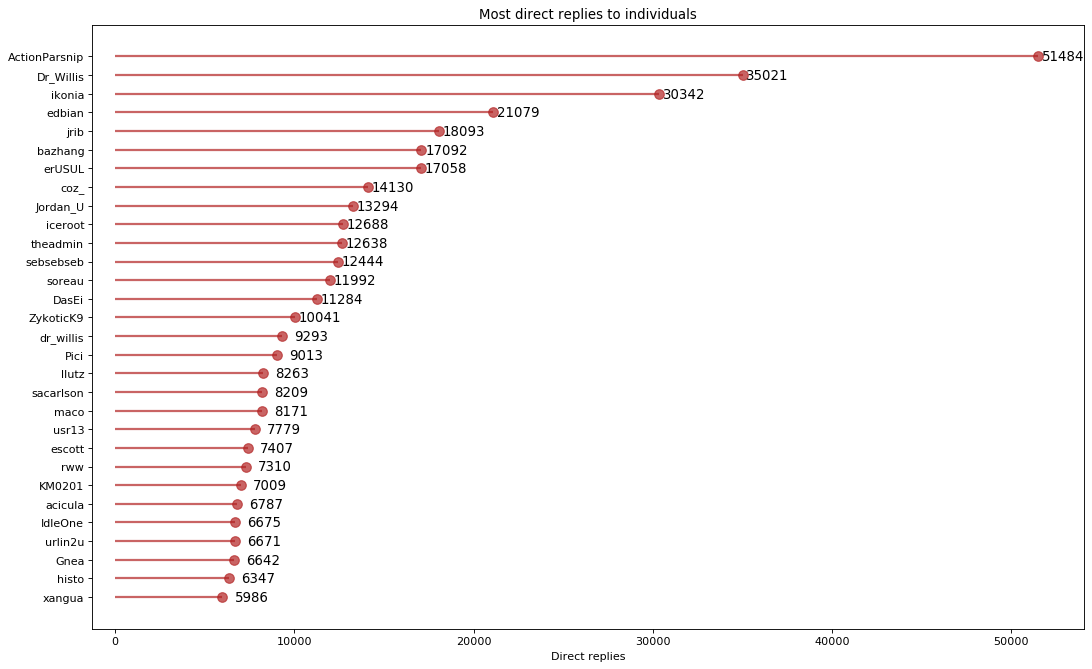

In [17]:
top_ind = thanked.sort_values(by=['msgs_ind'], ascending=False).head(30)
plot_ranks(top_ind, 'Most direct replies to individuals', 'msgs_ind', 'Direct replies')

In [18]:
top_thanks = thanked.sort_values(by=['gets_thanks'], ascending=False).head(30)
plot_ranks(top_thanks, 'Most thanked users', 'gets_thanks', 'Thanks received')

The two lists are similar. I'll see to combine them later on in this report. But first, let's see if we find anything interesting with the average message length.

### `avg_msg_len`

Let's have a look at the 30 users who write the shortest messages and those who write the longest messages:

In [19]:
thanked.sort_values(by=['avg_msg_len'], ascending=True).head(30)  # 30 users who write shortest messages

chats   op   msgs  avg_msg_len  msgs_ind  p_msgs_ind  \
user                                                                    
|sqwertle|           2    2     33     0.000000        25    0.757576   
maco              2030   55   8254     0.000242      8171    0.989944   
ActionParsnip    10436  774  55125     0.000345     51484    0.933950   
szal               889   62   2298     0.000435      2148    0.934726   
ikonia            5203  168  30715     0.000716     30342    0.987856   
rs0832             325   12   2772     0.000722      2763    0.996753   
sebsebseb         1745  150  12826     0.000858     12444    0.970217   
minimec            418   20   2128     0.000940      2111    0.992011   
ardchoille         617   42   2095     0.000955      1997    0.953222   
dr_willis         2566  342  10642     0.001034      9293    0.873238   
juniour            136  102    824     0.001214       294    0.356796   
gogeta             486   48   4058     0.001232      3952    0.973879   
bazhang           5707  197  17512     0.001256     17092    0.976016   
MeanEYE            324   32   1516     0.001319      1458    0.961741   
erUSUL            4615  255  17653     0.001529     17058    0.966295   
iceroot           3217  104  12884     0.001552     12688    0.984787   
abhi_nav           686  164   3496     0.001716      3048    0.871854   
Pici              3829  135   9269     0.001726      9013    0.972381   
airtonix          1138   70   5054     0.001781      4902    0.969925   
rww               3111  178   7721     0.001943      7310    0.946769   
root_              110   99    487     0.002053        86    0.176591   
almoxarife         604   72   2649     0.002265      2554    0.964137   
acicula           1692  125   7232     0.002351      6787    0.938468   
escott            1724   70   7513     0.002396      7407    0.985891   
tarzeau            180   17    788     0.002538       755    0.958122   
Us3r_Unfriendly    254   40   1547     0.002586      1416    0.915320   
meganerd           253   16   1033     0.002904       985    0.953533   
guntbert          2202  228   6171     0.002917      5772    0.935343   
xangua            3248  218   6588     0.003036      5986    0.908622   
indus              513   69   4268     0.003046      4026    0.943299   

                 gets_thanks  
user                          
|sqwertle|                 7  
maco                    1826  
ActionParsnip          14918  
szal                     710  
ikonia                  7408  
rs0832                   495  
sebsebseb               2447  
minimec                  727  
ardchoille               449  
dr_willis               3305  
juniour                  226  
gogeta                   749  
bazhang                 3183  
MeanEYE                  432  
erUSUL                  5409  
iceroot                 3086  
abhi_nav                 803  
Pici                    2072  
airtonix                1288  
rww                     1994  
root_                    101  
almoxarife               815  
acicula                 2441  
escott                  2861  
tarzeau                  189  
Us3r_Unfriendly          319  
meganerd                 295  
guntbert                1824  
xangua                  2173  
indus                    815

In [20]:
thanked.sort_values(by=['avg_msg_len'], ascending=False).head(30)  # 30 users who write longest messages

chats  op  msgs  avg_msg_len  msgs_ind  p_msgs_ind  \
user                                                                 
x9                  1   1     1        471.0         0         0.0   
remener_t           1   1     1        461.0         0         0.0   
bmathise            1   0     1        452.0         1         1.0   
electro             1   1     1        441.0         0         0.0   
Conan               1   1     1        441.0         0         0.0   
kaIpazan            1   1     1        440.0         0         0.0   
sacton3             1   1     1        439.0         0         0.0   
zminer              1   1     1        439.0         0         0.0   
Thrawnma            1   1     1        437.0         0         0.0   
raverjunpei         1   1     1        436.0         0         0.0   
Schuldig            1   1     1        435.0         0         0.0   
yugiohfan2011       1   1     1        434.0         0         0.0   
Logomachist         1   1     1        434.0         0         0.0   
dorian              1   1     1        433.0         0         0.0   
Cream2011           1   1     1        431.0         0         0.0   
StudyingHard        1   1     1        431.0         0         0.0   
boxlover            1   1     1        430.0         0         0.0   
jofo`               1   0     1        430.0         1         1.0   
phunk               1   0     1        429.0         1         1.0   
christina_          1   1     1        428.0         0         0.0   
Insaan              1   1     1        427.0         0         0.0   
hilko               1   1     1        421.0         0         0.0   
dsjackins           1   1     1        420.0         0         0.0   
sneha_chitre        1   1     1        413.0         0         0.0   
Bytesunfish         1   1     1        412.0         0         0.0   
GypsiRae            1   1     1        410.0         0         0.0   
ComputerNoobie      1   1     1        410.0         0         0.0   
rcross              1   1     1        409.0         0         0.0   
chicom9             1   1     1        404.0         0         0.0   
gr8audioguy         1   1     1        403.0         0         0.0   

                gets_thanks  
user                         
x9                        1  
remener_t                 1  
bmathise                  0  
electro                   1  
Conan                     1  
kaIpazan                  0  
sacton3                   4  
zminer                    4  
Thrawnma                  3  
raverjunpei               1  
Schuldig                  0  
yugiohfan2011             3  
Logomachist               2  
dorian                    1  
Cream2011                 1  
StudyingHard              2  
boxlover                  1  
jofo`                     0  
phunk                     0  
christina_                2  
Insaan                    1  
hilko                     3  
dsjackins                 0  
sneha_chitre              2  
Bytesunfish               2  
GypsiRae                  2  
ComputerNoobie            2  
rcross                    3  
chicom9                   3  
gr8audioguy               2

Interestingly, we find some familiar names in the list of users who write the shortest messages (ActionParsnip, ikonia, maco, etc.) Conversely, the users who write the longest messages, tend to write a single very long message in a single chat that they open. Maybe as users become more experienced they tend to be less verbose?

Let's see how average message length (`avg_msg_len`) correlates with number of direct replies (`msgs_ind`) and number of thanks received (`gets_thanks`):

In [21]:
def corr_plot(df, field_x, field_y, title):
    plt.figure(1, figsize=(20, 20))
    for ix, row in df.iterrows():
        plt.text(row[field_x], row[field_y], ix, size=12, bbox=dict(facecolor='red', alpha=0.1))
    plt.xlim((np.min(df[field_x]), np.max(df[field_x] + np.max(df[field_x]) * 0.10)))
    plt.ylim((np.min(df[field_y]), np.max(df[field_y] + np.max(df[field_y]) * 0.10)))
    plt.xlabel(field_x)
    plt.ylabel(field_y)
    plt.title(title)
    plt.show()

In [22]:
corr_plot(thanked[thanked.chats > 100], 'avg_msg_len', 'msgs_ind', 'Avg Message Length vs Direct Replies')

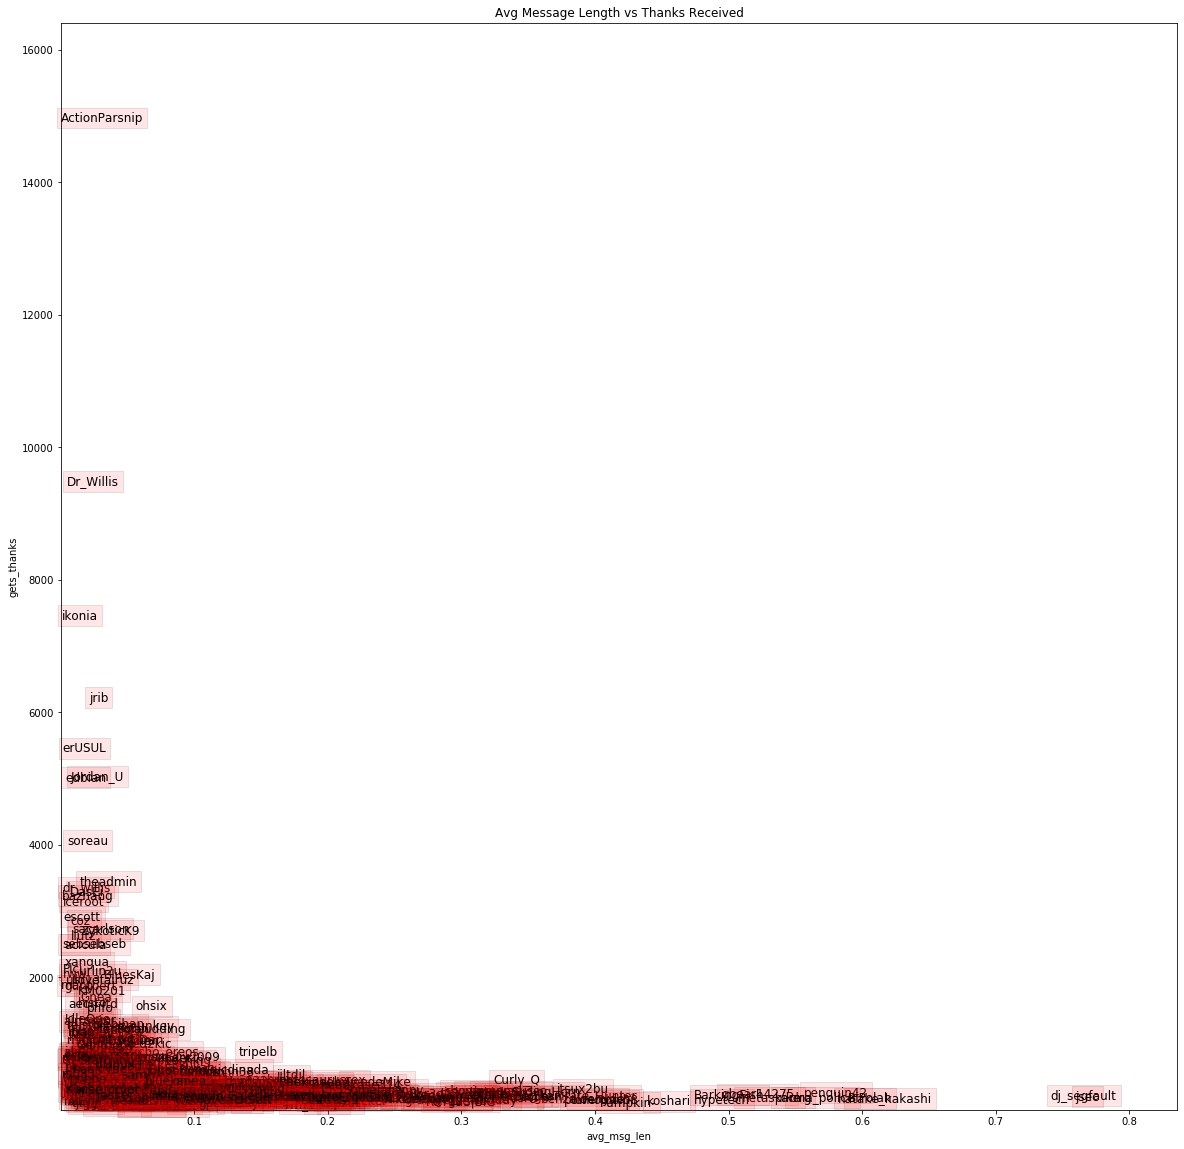

In [23]:
corr_plot(thanked[thanked.chats > 100], 'avg_msg_len', 'gets_thanks', 'Avg Message Length vs Thanks Received')

Both graphs are similar. Something to note is that we recognise familiar names on towards the upper-left part of the graph, suggesting that top helpers do keep to small messages. However, there seems to be quite a lot of names that get squashed towards the bottom. We could try to zoom in that area, but I'll try a slightly different visualisation instead. I'll colour in red the top 30 in the $y$ axis whilst keeping the rest in black/grey:

In [24]:
def corr_plot_colour(df, field_x, field_y, title):
    plt.figure(1, figsize=(10, 10))
    df_top =  df.loc[df.sort_values(by=[field_y], ascending=False).head(30).index]
    df_rest = df.loc[set(df.index).difference(set(df_top.index))]
    plt.scatter(df_rest[field_x], df_rest[field_y], alpha=0.2, c='black', s=30, label='rest')
    plt.scatter(df_top[field_x], df_top[field_y], alpha=1.0, c='red', s=30, label='top 30 in ' + field_y)
    plt.xlabel(field_x)
    plt.ylabel(field_y)
    plt.title(title)
    plt.show()

In [25]:
corr_plot_colour(thanked, 'avg_msg_len', 'msgs_ind', 'Avg Message Length vs Direct Replies')

In [26]:
corr_plot_colour(thanked, 'avg_msg_len', 'gets_thanks', 'Avg Message Length vs Thanks Received')

These two graphs show more clearly that users who (1) mostly reply to many, many users and (2) get thanked a lot, tend to write very short messages. 

And just for fun, let's see the correlation between users who reply to many users and users who get thanked a lot:



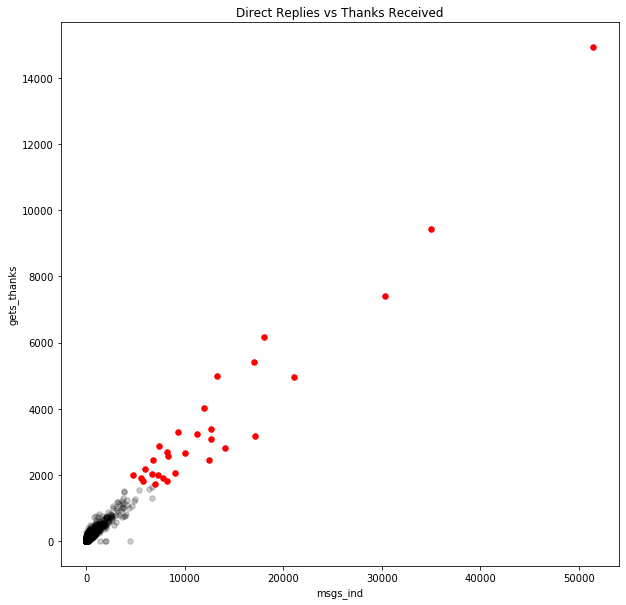

In [27]:
corr_plot_colour(thanked, 'msgs_ind', 'gets_thanks', 'Direct Replies vs Thanks Received')

This shows that these two variables are highly corelated.


## Combining rankings

It seems that the two main variables to consider when selecting customer service agents are number of direct replies (`msgs_ind`) and number of thanks received (`gets_thanks`). A simple way of combining them into a single ranking list is by simply multiplying the ranks of the top 30 agents on each list and then selecting the top 15 out of that. This is what I do in the following code:

In [28]:
def combine_rankings(df_list):
    proto_df = {'user': [], 'comb_rank': []}
    all_users = set()
    for df in df_list:
        all_users = all_users.union(set(df.index))
    for user in all_users:
        comb_rank = 1
        for df in df_list:
            if user in df.index:
                comb_rank *= df.index.get_loc(user) + 1
            else:
                comb_rank *= 31 # one after the last possible rank
        proto_df['user'].append(user)
        proto_df['comb_rank'].append(comb_rank)
    df = pd.DataFrame(proto_df)
    df = df.set_index('user')
    df = df.sort_values(by=['comb_rank'], ascending=True)
    return df

In [29]:
combo = combine_rankings([top_ind, top_thanks])
combo

comb_rank
user                    
ActionParsnip          1
Dr_Willis              4
ikonia                 9
jrib                  20
edbian                28
erUSUL                35
Jordan_U              54
bazhang               72
theadmin              99
soreau               104
coz_                 120
iceroot              130
DasEi                154
dr_willis            160
sebsebseb            228
ZykoticK9            255
sacarlson            304
escott               308
llutz                324
Pici                 374
acicula              500
rww                  552
maco                 560
usr13                567
urlin2u              621
xangua               630
KM0201               720
BluesKaj             775
ilovefairuz          806
IdleOne              806
Gnea                 868
guntbert             899
histo                899

The top 15 selected customer service agents are:

In [30]:
combo.head(15)

comb_rank
user                    
ActionParsnip          1
Dr_Willis              4
ikonia                 9
jrib                  20
edbian                28
erUSUL                35
Jordan_U              54
bazhang               72
theadmin              99
soreau               104
coz_                 120
iceroot              130
DasEi                154
dr_willis            160
sebsebseb            228